### **Importing required Libraries**

In [1]:
import re
import nltk
import spacy
import demoji
import pandas as pd 
import seaborn as sns
from textblob import TextBlob
from nltk import word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords
from langdetect import detect_langs
from matplotlib import pyplot as plt
import snscrape.modules.twitter as sntwitter
from spacy.lang.en.stop_words import STOP_WORDS

In [7]:
# Datafram output view setup
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth',-1)

C:\Users\chinn\AppData\Local\Temp\ipykernel_18932\3242638163.py:4: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



### **Data collection**

In [8]:
attributes_container = []
# dir(snscrape.modules.twitter)
# sntwitter.TwitterUserScraper() - for any twitter user fetch
for i, tweet in enumerate(sntwitter.TwitterSearchScraper('fedex since:2021-08-01 until:2022-08-01').get_items()):
    if i>1000:
        break
    attributes_container.append([tweet.user.username, tweet.date, tweet.likeCount, tweet.sourceLabel, tweet.content])
df = pd.DataFrame(attributes_container, columns=["User","Date Created","Number of likes", "Source of tweet", "Tweets"])
df.head()

,User,Date Created,Number of likes,Source of tweet,Tweets
0,ISLAND_THUNDER,2022-07-31 23:59:38+00:00,5,Twitter for iPhone,@fiant47 @Darkcrystal_fin @HopSwapFinance @THNDR_Token @chriskaleher @d3x_justin @cryptokuka @NewsCronos @RamenCash @That_FedEx_Guy @Blockchainwork5 @BradVonCroNos I been tellin y’all!!! LFG⚡️💎🚀🚀🚀 https://t.co/DfeWRrNvNo
1,MawResister,2022-07-31 23:59:35+00:00,0,Twitter for iPhone,@williamlegate @Jacquel25102704 My brother in law’s ashes were buried in a brown FedEx box. 🙄
2,CoonenWill,2022-07-31 23:58:37+00:00,0,Twitter for iPhone,I’m confused. @PGATOUR cannonballs into a pool of #saudibloodmoney then runs it through their personal laundromat known as the @FedEx Cup=FINE\n@LIVGolfInv is at least honest about the source=HORRIBLE. #Hypocrisy https://t.co/lTT2Fb63Nx
3,ISLAND_THUNDER,2022-07-31 23:58:31+00:00,4,Twitter for iPhone,@Darkcrystal_fin @HopSwapFinance @THNDR_Token @chriskaleher @d3x_justin @cryptokuka @NewsCronos @RamenCash @That_FedEx_Guy @Blockchainwork5 @BradVonCroNos LFG @Darkcrystal_fin #GangGang🌴✊🏽♾ https://t.co/LpUERAOtZc
4,graybrigade,2022-07-31 23:58:02+00:00,1,Twitter for iPhone,@TracksideMikeN @K_Kisner Like you said a lot of guys trying to get to FedEx. Similar to the old Fall lineup guys trying to keep Tour card….


### **Data Cleaning**

In [9]:
def textclean(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # removed @mentions
    text = re.sub(r'#','',text) # remove the hash tag
    text = re.sub(r'RT[\s]+','',text) # remove RT
    text = re.sub(r'https?:\/\/\S+','',text) # Remove the hyper link
    text = re.sub(r'&amp;','',text) # remove &amp;
    text = re.sub(r'\s{2,}',' ', text)  # remove extra spaces
    text = re.sub(r'^\s+','',text)  # remove starting extra spaces
    return text

def clean(text):
    emoji = demoji.findall(text)
    for emot in emoji:
        text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)
    return text


def nostopwords(text):
  nlp = spacy.load('en_core_web_sm')
  sentence = nlp(text)
  text = [word.text.strip() for word in sentence if not word.is_stop and not word.is_punct]
  return text

def n_words(df):
  tweet_tokens = [word_tokenize(item) for item in df.Tweets]
  len_tokens = []
  for i in range(len(tweet_tokens)):
    len_tokens.append(len(tweet_tokens[i]))
  return len_tokens

def getLanguages(df):
  languages = []
  for row in range(len(df)):
    languages.append(detect_langs(df.iloc[row, 3]))
  languages = [str(lang).split(':')[0][1:] for lang in languages]
  return languages
    

def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity  # type: ignore
def getPolarity(text):
  return TextBlob(text).sentiment.polarity  # type: ignore

def getSentiment(score):
  if score < 0:
    return "Negative"
  if score == 0:
    return "Neutral"
  else:
    return "Positive"


In [10]:
df['Tweets'] = df['Tweets'].apply(textclean)
# df['Tweets'] = df['Tweets'].apply(nostopwords)
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)
df['n_words'] = n_words(df)
df['languages'] = getLanguages(df)
df['sentiment'] = df['Polarity'].apply(getSentiment)
df.head()

,User,Date Created,Number of likes,Source of tweet,Tweets,Subjectivity,Polarity,n_words,languages,sentiment
0,ISLAND_THUNDER,2022-07-31 23:59:38+00:00,5,Twitter for iPhone,_fin _Token _justin _FedEx_Guy I been tellin y’all!!! LFG⚡️💎🚀🚀🚀,0.000,0.000,14,en,Neutral
1,MawResister,2022-07-31 23:59:35+00:00,0,Twitter for iPhone,My brother in law’s ashes were buried in a brown FedEx box. 🙄,0.000,0.000,16,en,Neutral
2,CoonenWill,2022-07-31 23:58:37+00:00,0,Twitter for iPhone,I’m confused. cannonballs into a pool of saudibloodmoney then runs it through their personal laundromat known as the Cup=FINE is at least honest about the source=HORRIBLE. Hypocrisy,0.575,-0.025,31,en,Negative
3,ISLAND_THUNDER,2022-07-31 23:58:31+00:00,4,Twitter for iPhone,_fin _Token _justin _FedEx_Guy LFG _fin GangGang🌴✊🏽♾,0.000,0.000,7,en,Neutral
4,graybrigade,2022-07-31 23:58:02+00:00,1,Twitter for iPhone,_Kisner Like you said a lot of guys trying to get to FedEx. Similar to the old Fall lineup guys trying to keep Tour card….,0.300,0.050,27,en,Positive


In [11]:
df.loc[df['Number of likes'] == max(df['Number of likes'])]

,User,Date Created,Number of likes,Source of tweet,Tweets,Subjectivity,Polarity,n_words,languages,sentiment
152,ryanpistana,2022-07-31 22:13:42+00:00,808,Twitter for iPhone,This corner is brought to you by FedEx,0.0,0.0,8,en,Neutral


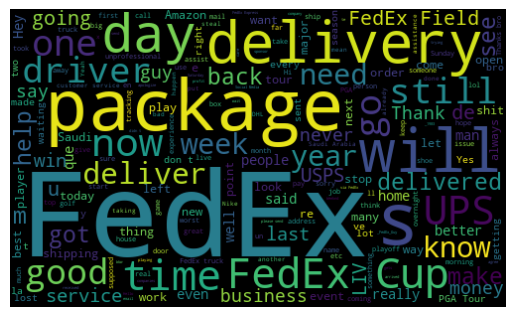

In [12]:
allwords = ' '.join([tweet for tweet in df['Tweets']])
wordcloud = WordCloud(width = 500, height= 300, random_state=21, max_font_size=119).generate(allwords)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Polarity', ylabel='Subjectivity'>

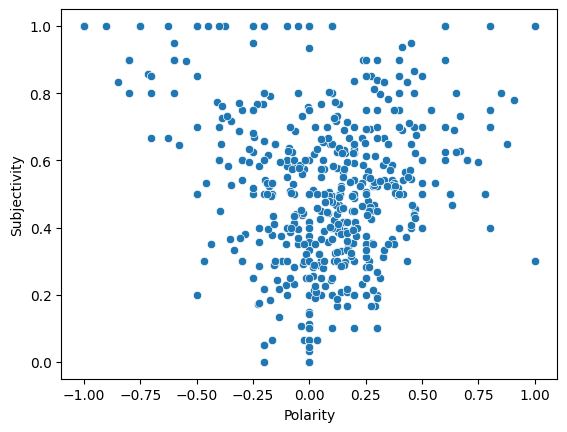

In [13]:
sns.scatterplot(df.Polarity, df.Subjectivity) # type: ignore 

In [14]:
df.sentiment.value_counts()

Neutral     424
Positive    384
Negative    193
Name: sentiment, dtype: int64

In [15]:
sortedf = df.sort_values(by=['Polarity'])
neudf = []
posdf =  []
negdf = []
for i in range(0, sortedf.shape[0]):
    if(df['sentiment'][i]=='Neutral'):
        neudf.append(sortedf.Tweets[i])
    elif(df['sentiment'][i]=='Positive'):
        posdf.append(sortedf['Tweets'][i])
    else:
        negdf.append(sortedf.Tweets[i])
neudf = pd.DataFrame(neudf)
neudf

,0
0,_fin _Token _justin _FedEx_Guy I been tellin y’all!!! LFG⚡️💎🚀🚀🚀
1,My brother in law’s ashes were buried in a brown FedEx box. 🙄
2,_fin _Token _justin _FedEx_Guy LFG _fin GangGang🌴✊🏽♾
3,"Let’s not forget his pension, his FedEx money, his sponsors. And his dignity…and earnings that will last for years to come …"
4,you are getting blood money from Saudi Arabia and
...,...
419,who tf was at fedex?
420,Hundreds of FedEx packages are found in Alabama woods via
421,Call FedEx Saudi!
422,"FedEx, the PGA’s largest sponsor, is making billions on the backs of Saudi Arabia."


Text(0.5, 1.0, 'Sentiment Analysis on FedEx')

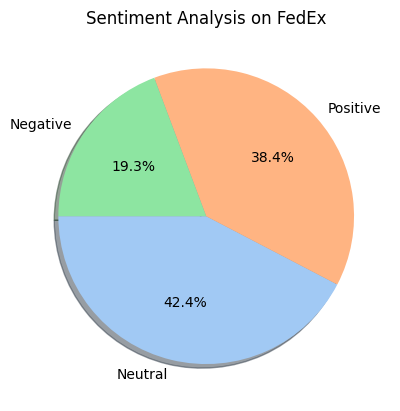

In [16]:
from turtle import title
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('pastel')[0:3]
plt.pie(df.sentiment.value_counts(), labels=['Neutral', 'Positive', 'Negative'],autopct='%1.1f%%', colors=colors, startangle=180, shadow=True)
plt.title('Sentiment Analysis on FedEx')

<BarContainer object of 3 artists>

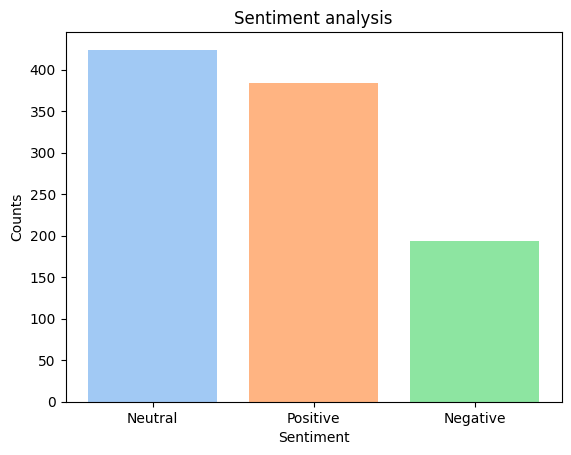

In [17]:
plt.title('Sentiment analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.bar(df.sentiment.value_counts().index, df.sentiment.value_counts(), color=colors)

In [18]:
import yfinance as yf
import pandas as pd

df = yf.download('FDX', '2019-12-31', '2020-08-01')
df['date'] = df.index
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,date
Date,,,,,,,
2019-12-31,149.220001,151.570007,148.750000,151.210007,145.313858,2153400,2019-12-31
2020-01-02,152.419998,155.100006,151.600006,155.100006,149.052170,3027600,2020-01-02
2020-01-03,152.500000,153.339996,151.839996,153.179993,147.207047,2216500,2020-01-03
2020-01-06,151.250000,153.550003,150.169998,153.300003,147.322357,2389700,2020-01-06
2020-01-07,153.360001,155.220001,152.339996,154.800003,148.763901,2140100,2020-01-07


In [19]:
import plotly.express as px
fig = px.line(df, x='date', y='Close', labels={'date':'Date', 'Close':'Price (in USD)'}, title='FedEx stock price')
fig.show()

In [20]:
# cloud = WordCloud(background_color='white').generate('This is me, you now who it is this is what it is')
# plt.imshow(cloud, interpolation='bilinear')
# plt.show()
# # Import the stop words
# from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# # Define the stop words
# my_stop_words = ENGLISH_STOP_WORDS.union(['airline', 'airlines', '@'])

# # Build and fit the vectorizer
# vect = CountVectorizer(stop_words=my_stop_words)
# vect.fit(tweets.text)

# # Create the bow representation
# X_review = vect.transform(tweets.text)
# # Create the data frame
# X_df = pd.DataFrame(X_review.toarray(), columns=vect.get_feature_names())
# print(X_df.head())

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
import torch
tokens = tokenizer.encode('That lettuce that’s outlasting	', return_tensors = 'pt')
result = model(tokens)
torch.argmax(result.logits)

tensor(1)

In [ ]:
from textblob import TextBlob
TextBlob('He is a good person').sentiment

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

'LABEL_1'

In [ ]:
inputs = tokenizer("you are very bad", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# predicted_class_id = logits.argmax().item()
torch.argmax(logits)


tensor(1)

### **Model building**

In [ ]:
# import findspark
# findspark.init()

In [ ]:
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName('sa').getOrCreate()
# spark

In [2]:
import gradio as gr
import pandas as pd
from nltk import word_tokenize

def textclean(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # removed @mentions
    text = re.sub(r'#','',text) # remove the hash tag
    text = re.sub(r'RT[\s]+','',text) # remove RT
    text = re.sub(r'https?:\/\/\S+','',text) # Remove the hyper link
    text = re.sub(r'&amp;','',text) # remove &amp;
    text = re.sub(r'\s{2,}',' ', text)  # remove extra spaces
    text = re.sub(r'^\s+','',text)  # remove starting extra spaces
    return text

def preprocessing(data, textclean):
    df = pd.read_csv(data.name)
    df.rename(columns = {df.columns[0]: 'text'}, inplace=True)
    df_cleaned = df.text.apply(textclean) if textclean else 0
    return df, df_cleaned


iface = gr.Interface(fn=preprocessing,
            inputs= [gr.inputs.File(label='CSV file'),
                    'checkbox'],
            outputs= [gr.outputs.Dataframe(label='Original data'),
                     gr.outputs.Dataframe(label='Cleaned data')], 
            allow_flagging='never',
            title='NLP text automation')
iface.launch(enable_queue=False, debug = True)


c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\inputs.py:346: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\deprecation.py:40: UserWarning: `keep_filename` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\outputs.py:127: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\routes.py", line 283, in run_predict
    output = await app.blocks.process_api(
  File "c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\blocks.py", line 936, in process_api
    result = await self.call_function(fn_index, inputs, iterator)
  File "c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\blocks.py", line 777, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\anyio\to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages\anyio\_backends\_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "c:\Users\chinn\AppData\Local\Programs\Python\Python38\lib\site-packages

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x224869179a0>, 'http://127.0.0.1:7861/', None)

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

C:\Users\chinn\AppData\Local\Temp\ipykernel_1964\497376691.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [1]:
import pandas as pd
from nltk import word_tokenize
df = pd.read_csv('assets/Precily_Text_Similarity.csv')
df.rename(columns = {df.columns[0]: 'text'}, inplace=True)
tokens = [word_tokenize(item) for item in df.text]
df['tokens'] = tokens

In [15]:
for i in df.columns:
    print(df[i])

0       broadband challenges tv viewing the number of ...
1       rap boss arrested over drug find rap mogul mar...
2       player burn-out worries robinson england coach...
3       hearts of oak 3-2 cotonsport hearts of oak set...
4       sir paul rocks super bowl crowds sir paul mcca...
                              ...                        
2995    uk directors guild nominees named martin scors...
2996    u2 to play at grammy awards show irish rock ba...
2997    pountney handed ban and fine northampton coach...
2998    belle named  best scottish band  belle & sebas...
2999    criminal probe on citigroup deals traders at u...
Name: text, Length: 3000, dtype: object
0       gardener wins double in glasgow britain s jaso...
1       amnesty chief laments war failure the lack of ...
2       hanks greeted at wintry premiere hollywood sta...
3       redford s vision of sundance despite sporting ...
4       mauresmo opens with victory in la amelie maure...
                              ..

In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def stopwords(df, column):
    
    stop_words = stopwords.words('english')
    df['stop_tokens'] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    return df

stopwords(df, 'text')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chinn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: 'function' object has no attribute 'words'

In [13]:
import spacy

def nostopwords(text):
  nlp = spacy.load('en_core_web_sm')
  sentence = nlp(text)
  text = [word.text.strip() for word in sentence if not word.is_stop and not word.is_punct]
  return text

nostopwords()

KeyError: 'broadband challenges tv viewing the number of europeans with broadband has exploded over the past 12 months  with the web eating into tv viewing habits  research suggests.  just over 54 million people are hooked up to the net via broadband  up from 34 million a year ago  according to market analysts nielsen/netratings. the total number of people online in europe has broken the 100 million mark. the popularity of the net has meant that many are turning away from tv  say analysts jupiter research. it found that a quarter of web users said they spent less time watching tv in favour of the net  the report by nielsen/netratings found that the number of people with fast internet access had risen by 60% over the past year.  the biggest jump was in italy  where it rose by 120%. britain was close behind  with broadband users almost doubling in a year. the growth has been fuelled by lower prices and a wider choice of always-on  fast-net subscription plans.  twelve months ago high speed internet users made up just over one third of the audience in europe; now they are more than 50% and we expect this number to keep growing   said gabrielle prior  nielsen/netratings analyst.  as the number of high-speed surfers grows  websites will need to adapt  update and enhance their content to retain their visitors and encourage new ones.  the total number of europeans online rose by 12% to 100 million over the past year  the report showed  with the biggest rise in france  italy  britain and germany.  the ability to browse web pages at high speed  download files such as music or films and play online games is changing what people do in their spare time.  a study by analysts jupiter research suggested that broadband was challenging television viewing habits. in homes with broadband  40% said they were spending less time watching tv. the threat to tv was greatest in countries where broadband was on the up  in particular the uk  france and spain  said the report. it said tv companies faced a major long-term threat over the next five years  with broadband predicted to grow from 19% to 37% of households by 2009.  year-on-year we are continuing to see a seismic shift in where  when and how europe s population consume media for information and entertainment and this has big implications for tv  newspaper and radio   said jupiter research analyst olivier beauvillian.'